# Fourier-Spectral Interpolation

> _h/t Steve DeWitt (ORNL) for the concept and Daniel Wheeler (NIST) for the derivation_

We have data $v$ on a coarse mesh $\mathrm{X}$ that we wish to compare to a gold standard field $u$ on a fine mesh $\mathrm{X}$.  
This is simplest to implement by zero-padding the Fourier-transformed data $\hat{v}$ to match the shape of $\mathrm{Y}$, then transforming back to real space.  
Conceptually, this involves some work.

> _N.B.:_
> 1. Regardless of the simulation domain, the interpolation domain spans $\left[0, 2\pi\right]$.
> 2. The interpolation domain must be periodic; in the summations over real space, the first point
>    $(j=0)$ is skipped, since the last point $(j=N)$ provides its full value.

## Coarse Data

Consider field values $v$ embedded on the mesh $\mathrm{X}$:

| index _j_ | 0     | 1     | $\cdots$ | _N_   |
| ---       | ---   | ---   | ---      | ---   |
| coord     | $x_0$ | $x_1$ | $x_j$    | $x_N$ |
| value     | $v_0$ | $v_1$ | $v_j$    | $v_N$ |

where $x_j$ takes values on $\left[0, 2\pi\right]$ and the uniform spacing between points is $h = \frac{2\pi}{N}$.

The forward transform of $v$ is

$$ \hat{v}_k = \sum\limits_{j=1}^{N} e^{-\mathrm{i}kx_j}\, v_j $$

and the reverse transform of $\hat{v}$ is

$$ v_j = \frac{h}{2\pi} \sum\limits_{k=-\frac{N}{2}}^{\frac{N}{2}-1} e^{\mathrm{i}kx_j}\, \hat{v}_k $$

We also have the interpolation function approximating $v_j$:

$$ f(\xi) = \frac{h}{2\pi} \sum\limits_{k=-\frac{N}{2}}^{\frac{N}{2}-1} e^{\mathrm{i}k\xi}\, \hat{v}_k $$

## Fine Mesh

Now consider a finer mesh $\mathrm{Y}$ with empty values $u$:

| index _p_ | 0     | 1     | 2     | 3     | 4     | $\cdots$ | _M_-1     | _M_   |
| ---       | ---   | ---   | ---   | ---   | ---   | ---      |  ---      | ---   |
| coord     | $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_p$    | $y_{M-1}$ | $y_M$ |
| value     | $u_0$ | $u_1$ | $u_2$ | $u_3$ | $u_4$ | $u_p$    | $u_{M-1}$ | $u_M$ |

where $y_p$ takes values on $\left[0, 2\pi\right]$ and the uniform spacing between points is $\ell = \frac{2\pi}{M}$ with $M>N$.

The reverse transform of $\hat{u}$ is

$$ u_p = \frac{\ell}{2\pi} \sum\limits_{k'=-\frac{M}{2}}^{\frac{M}{2}-1} e^{\mathrm{i}k' y_p}\, \hat{u}_{k'} $$

and the forward transform of $u$ is

$$ \hat{u}_{k'} = \sum\limits_{p=1}^{M} e^{-\mathrm{i}k'y_p}\, u_p $$

## Clever Tricks

Now, let's substitute our interpolant $f(y_p)$ for $u_p$ in the forward transformation:

$$ \hat{u}_{k'} = \sum\limits_{p=1}^{M} e^{-\mathrm{i}k'y_p} \left\{ \frac{h}{2\pi} \sum\limits_{k=-\frac{N}{2}}^{\frac{N}{2}-1} e^{\mathrm{i}ky_p}\, \hat{v}_k \right\} $$

Factoring out the constants and changing the order of summation, noting that $\hat{v}_k$ is independent of the real-space index $p$,

$$ \hat{u}_{k'} = \frac{h}{2\pi} \sum\limits_{k=-\frac{N}{2}}^{\frac{N}{2}-1} \hat{v}_k \sum\limits_{p=1}^{M} e^{\mathrm{i}(k - k')y_p} $$

Now, recognizing the Kronecker delta function

$$ \delta_{k - k'} = \frac{1}{M} \sum\limits_{p=1}^{M} e^{-\mathrm{i}(k - k')y_p} $$

and substituting, along with $\frac{h}{2\pi}=\frac{1}{N}$, we have

$$ \hat{u}_{k'} = \frac{M}{N} \sum\limits_{k=-\frac{N}{2}}^{\frac{N}{2}-1} \hat{v}_k \delta_{k - k'} $$

$$ \hat{u}_{k'} = \begin{cases}
\frac{M}{N} \hat{v}_k, & -\frac{N}{2} \leq k' \leq \frac{N}{2}-1 \\
0, & \mathrm{otherwise.}\\
\end{cases} $$

## Illustrative Example (1D)

Take a coarse grid with $N=4$ points and a fine grid with $M=8$ points. Then

| $k'$ | $-4$ | $-3$ | $-2$ | $-1$ | $0$ | $1$ | $2$ | $3$ |
| ---  | ---  | ---  | ---  | ---  | --- | --- | --- | --- |
| $\hat{u}_{k'}$ | $0$ | $0$ | $\frac{M}{N}\hat{v}_0$ | $\frac{M}{N}\hat{v}_1$ | $\frac{M}{N}\hat{v}_2$ | $\frac{M}{N}\hat{v}_3$ | $0$ | $0$ |

So, Fourier interpolation of coarse data onto the fine mesh requires

0. 
1. Transform the coarse data of size $N$ to get $\hat{v}_k$
2. Zero-pad the transformed data, centering it in a reciprocal-space mesh of size $M$
3. Scale the padded transformed values by $\frac{M}{N}$ to get $\hat{u}_{k'}$
4. Take the reverse Fourier transform to get $u_p$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as FFT

L = 2 * np.pi

def pad(y, N, M):
    z = (M - N) // 2
    return np.pad(y, z)

# 1D test

In [2]:
def interp1D(v, M):
    N = v.shape[0]
    v_hat = FFT.fftshift(FFT.fft(v))
    u_hat = pad(v_hat, N, M)
    u = M / N * FFT.ifft(FFT.ifftshift(u_hat)).real
    
    return u

def fun1D(x):
    return np.exp(np.sin(x))  # just need a periodic function on [0, 2π]

def data1D(N):
    x = np.linspace(0, L - L/N, N)
    v = fun1D(x)

    return x, v

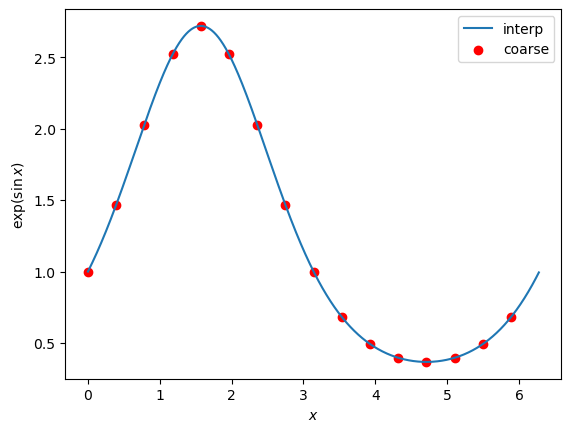

In [3]:
N = 16
x, v = data1D(N)

M = 1024
y = np.linspace(0, L - L / M, M)
U = fun1D(y)

u = interp1D(v, M)

plt.plot(y, u, label="interp");
plt.scatter(x, v, label="coarse", color="red");
plt.xlabel("$x$");
plt.ylabel("$\\exp(\\sin x)$");
plt.legend(loc="best");

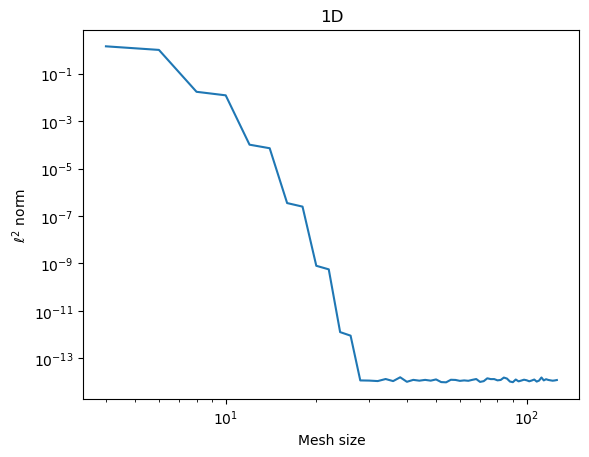

In [4]:
N1s = np.arange(4, M//8, 2)
Z1s = []

for N in N1s:
    x, v = data1D(N)
    u = interp1D(v, M)
    Z1s += [np.linalg.norm(u - U)]

plt.loglog(N1s, Z1s);
plt.title("1D");
plt.xlabel("Mesh size");
plt.ylabel("$\ell^2$ norm");

## 2D test

In [5]:
def interp2D(v, M):
    N = v.shape[0]
    v_hat = FFT.fftshift(FFT.fft2(v))
    u_hat = pad(v_hat, N, M)
    u = (M / N)**2 * FFT.ifft2(FFT.ifftshift(u_hat)).real
    
    return u

def fun2D(x, y):
    return np.exp(np.sin(x - np.pi/2 * np.cos(y)))  # just need a periodic function on [0, 2π] × [0, 2π]

def data2D(N):
    X = np.linspace(0, L - L/N, N)
    x, y = np.meshgrid(X, X)
    v = fun2D(x, y)

    return v

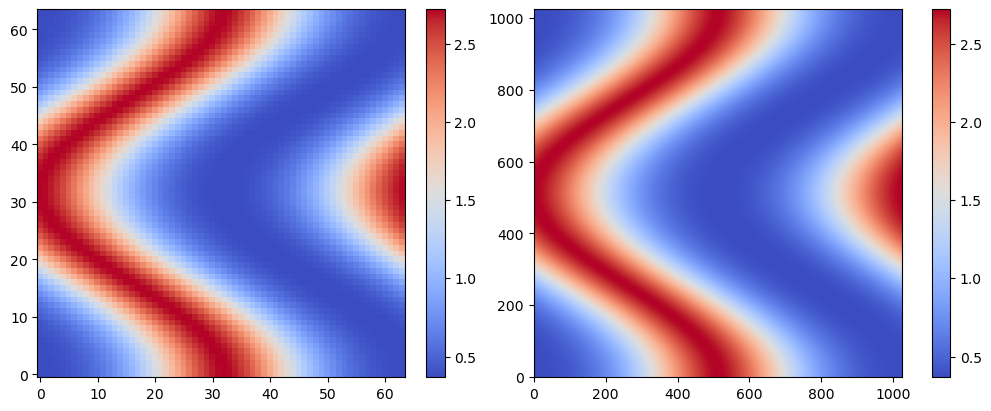

In [6]:
N = 64
v = data2D(N)

M = 1024
u = interp2D(v, M)

fig, ax = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
fig.colorbar(ax[0].imshow(v, cmap="coolwarm", origin="lower", interpolation=None));
fig.colorbar(ax[1].imshow(u, cmap="coolwarm", origin="lower", interpolation=None));

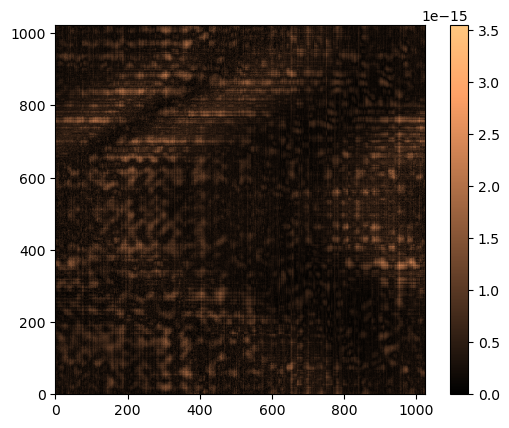

In [7]:
Y = np.linspace(0, L - L/M, M)
x, y = np.meshgrid(Y, Y)
U = fun2D(x, y)

plt.colorbar(plt.imshow(np.absolute(u - U), cmap="copper", origin="lower", interpolation=None));

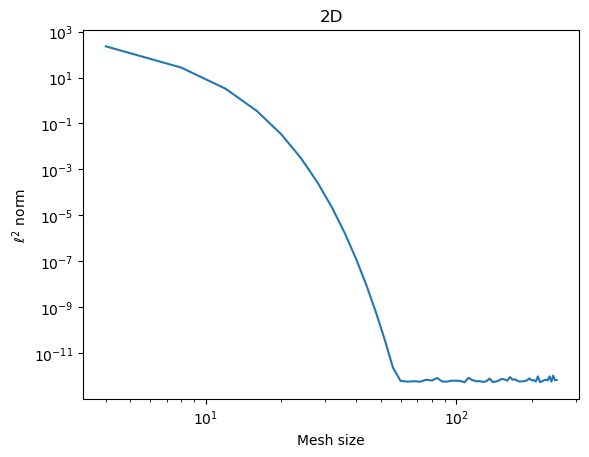

In [8]:
N2s = np.arange(4, M//4, 4)
Z2s = []

for N in N2s:
    v = data2D(N)
    u = interp2D(v, M)
    Z2s += [np.linalg.norm(u - U)]

plt.loglog(N2s, Z2s);
plt.title("2D");
plt.xlabel("Mesh size");
plt.ylabel("$\ell^2$ norm");